In [23]:
import sys
import seaborn as sns

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../Data/MD-PERMEATION/'
db_data = databank(path)
systems = db_data.get_systems()

In [3]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sn
import os
import scipy.stats
from scipy import stats

def CalcAreaPerMolecule(system):
    path = system['path']
    APLpath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    APLpath = APLpath + 'apl.json'
    #try:
    f = open(APLpath)
    APLdata = json.load(f)
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    return(APL)
    #except:
    #    print('apl.json not found from' + APLpath)
        
def calcArea(system):
    APL = CalcAreaPerMolecule(system)
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid*APL/2

def GetThickness(system):
    path = system['path']
    ThicknessPath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    ThicknessPath = ThicknessPath + 'thickness.json'
    #try:
    f = open(ThicknessPath)
    thickness = json.load(f)
    return(thickness)
    #except:
    #    pass
    #    print('thickness.json not found from' + system['path'])
    

def calcLipidFraction(system, lipid):
    NlipidTOT = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NlipidTOT += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if lipid in molecule:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Nlipid/NlipidTOT

def chargedFraction(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Ncharged = 0
    chargedlipids = ['POPG', 'POPS', 'DPPG', 'DOPS', 'POPI', 'SAPI', 'SLPI', 'DHMDMAB']
    for molecule in system['COMPOSITION']:
        if molecule in chargedlipids:
            Ncharged += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Ncharged/Nlipid


def getHydrationLevel(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    return Nwater/Nlipid


def getWaterPermeationRate(system):
    path = system['path']
    with open(path + 'Counting_events.txt', 'r') as f:
        last_line = f.readlines()[-1]
    last_line = last_line.split()
    time = float(last_line[0])
    count = float(last_line[1])
    area = calcArea(system)
    #rate = count / (time * area)  #1/(ns*Å^2)
    rate = count / (time)  #1/ns
    thickness = GetThickness(system)*10
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    P = 0.5*rate*10**9/(area*10**-20 * 33.3679*10**27)
    return P

def getWaterLateralDiffusion(system):
    path = system['path']
    waterDIFFUSIONpath = path.replace('../Data/MD-PERMEATION/', '../Data/WATERdiffusion/')
    waterDIFFUSIONpath = waterDIFFUSIONpath + 'WATERlateralMSD.xvg'
    D = float(os.popen('grep D ' + waterDIFFUSIONpath + " | grep = | awk '{print $5}'").read())
    return D
    
def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty])
    plt.plot(xPropertyData,yPropertyData,'.')
    
def averageOrderParameters(system):
    
    #DataBankPath = '../../Databank/Data/'
    #path = DataBankPath + system['path']
    
    pathTMP = system['path']
    path = pathTMP.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = path + lipid + 'OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1
                    
    return sn1sum/sn1count, sn2sum/sn2count



In [14]:
permeationVStemperature = {}
ID = 0
for system in systems:
    path = system['path']
    
    try:
        rate = getWaterPermeationRate(system)
    except:
        print('Water permeation failed, setting rate to 0: ' + path)
        rate = 0
        #continue
    
    if rate > 0.15:
        continue
    
    WaterLateralDiffusion = getWaterLateralDiffusion(system)
    
    if WaterLateralDiffusion > 15:
        continue
    
    #if rate > 0:
    PermeationDiffusionRatio = rate/WaterLateralDiffusion
    #else:
    #    PermeationDiffusionRatio = 'nan'
    
    APL = CalcAreaPerMolecule(system)
    
    try:
        thickness = GetThickness(system)
    except:
        thickness = 0 #float('nan')

    if thickness < 3:
        continue
        
    area = calcArea(system)   
    
    tailOPavg = np.average(averageOrderParameters(system))
    #print(tailOPavg)
    if str(tailOPavg) == 'nan':
        print(system)
    
    
    hydration = getHydrationLevel(system)
    
    CholFraction = calcLipidFraction(system, 'CHOL')
    
    POPGFraction = calcLipidFraction(system, 'POPG')
    
    POPSFraction = calcLipidFraction(system, 'POPS')
    
    POPEFraction = calcLipidFraction(system, 'POPE')
    
    ChargedFraction = chargedFraction(system)
    
    temperature = system['TEMPERATURE']
    
    SimLength = system['TRJLENGTH'] - system['PREEQTIME']
    
    try:
        ForceField = system['FF']
    except:
        ForceField = 'Unknown'
    
    if thickness == 0:
        continue
    
    ID += 1
    permeationVStemperature[ID] = {
        'path': path, 
        'permeation': rate, 
        'WaterLateralDiffusion' : WaterLateralDiffusion,
        'APL': APL, 
        'thickness': thickness,
        'TailOrder' : tailOPavg,
        'hydration': hydration,
        'temperature': temperature ,
        'ChargedFraction': ChargedFraction,
        'CholFraction': CholFraction,
        'POPGFraction': POPGFraction,
        'POPSFraction': POPSFraction,
        'POPEFraction': POPEFraction,
        'ForceField': ForceField,
        'SimLenght': SimLength,
        #'PermeationDiffusionRatio' : PermeationDiffusionRatio,
        #'area' : area,
    }
        
        
    #!ls {path}
    #for key in system:
    #    print(key, ':',system[key])
    #print('')

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/294/580/294580f76f29b1bd472b1bfd3ac96bd2c0afc3d8/f9d04d782c95d988832179eb8bf7e78380039dbc/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/888/c03/888c031cd88bd97a5584a120dee76bf673e438ff/369daa4fed207d6e3d3199466c3f260535334f11/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/ea0/d5a/ea0d5a1550d15ecabd0ffc0a27f59a7c01f61b83/570401bcf40f667dc9b035d8d5519aeb4a3fa072/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/54b/650/54b6503812c7cd81137b04d302569bcd08aca03b/b56c1f05e72a73558cf1a7ac399a8420648399be/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/9b7/641/9b764160ba3d106354f828531981eef8b34e8306/262e4fd83c0f60c7de432db3961400e314457a12/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/d6d/09c/d6d09c4458210fdf02a4be6b84e90f2ccb3cd878/7d2df313040867886d85e66f378f5689d6505517/
Water permeation failed, setting rate to 0: ../Data/MD-PER

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/351/942/3519421ff6c7df40e1da7ac6b6e9ea4d06c911ca/1419f364222a22aadc90d4ec0963e18173e1df2a/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/f40/bb6/f40bb6ab5d44402be07059e8df74b5a8200f031e/6774168dfec0a5a7377c8a46341eba603f320cf7/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/310/972/310972e588b9d3b8bb3049c5a4ee1977889c6559/a4d8e0ad017d67cfb566b576d573778c671c4cba/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/325/122/325122b1f8af70a4fc3001c4781c96773ca448ab/17740ef7cfae47602aece493a725deba4fdd47b8/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/02b/984/02b98418d9965749ac943ecae9627cfdd1dfbdcd/7339faa76da6c93cfee03e59f399e2eed1628b53/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/dc7/f14/dc7f14a4f247140f07204a8e14f5a2a5ff8f58ca/df63fa3bbb96e0f5fb742ac67341e02a3960e555/
Water permeation failed, setting rate to 0: ../Data/MD-PER

0.0011251857961875609


/home/samuli/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

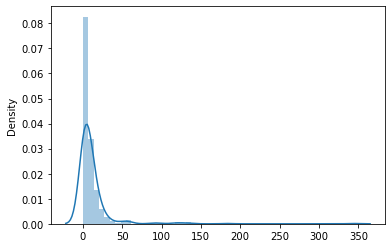

In [26]:
#print(system)
perm = []
sumIND = 0
sumPERM = 0
for i in permeationVStemperature:
    perm.append(permeationVStemperature[i]['permeation']*10**6)
    sumPERM += permeationVStemperature[i]['permeation']
    sumIND += 1
    #sumPERM += permeationVStemperature[i]['SimLenght'] * permeationVStemperature[i]['permeation']
    #sumIND += permeationVStemperature[i]['SimLenght']
print(sumPERM*10**2/sumIND)

sns.distplot(perm)

(0.0, 0.0001)

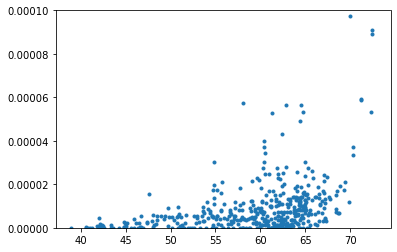

In [7]:
plotCorrelation('APL','permeation',permeationVStemperature)
plt.ylim([0,10**-4])

(3.0, 6.0)

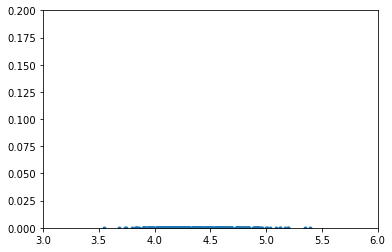

In [7]:
plotCorrelation('thickness','permeation',permeationVStemperature)
plt.ylim([0,0.2])
plt.xlim([3,6])

(0.0, 0.2)

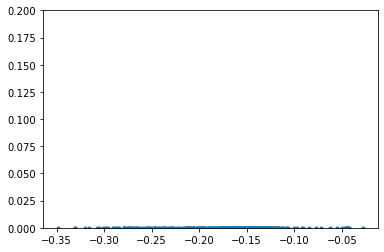

In [8]:
plotCorrelation('TailOrder','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

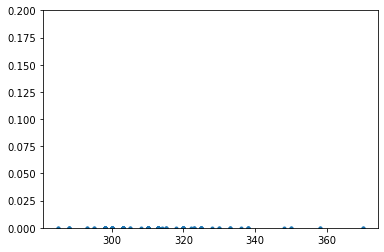

In [9]:
plotCorrelation('temperature','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

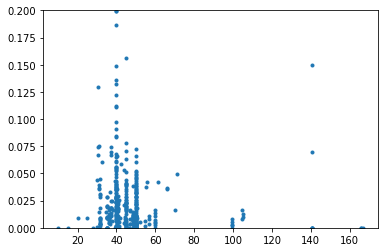

In [8]:
plotCorrelation('hydration','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 11.0)

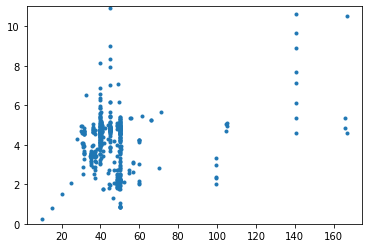

In [9]:
plotCorrelation('hydration','WaterLateralDiffusion',permeationVStemperature)
plt.ylim([0,11])

In [10]:
plotCorrelation('hydration','PermeationDiffusionRatio',permeationVStemperature)
#plt.ylim([0,0.05])

KeyError: 'PermeationDiffusionRatio'

(0.0, 0.2)

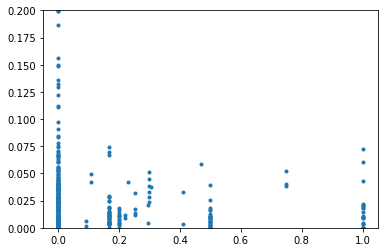

In [11]:
plotCorrelation('ChargedFraction','permeation',permeationVStemperature)
plt.ylim([0,0.2])

(0.0, 0.2)

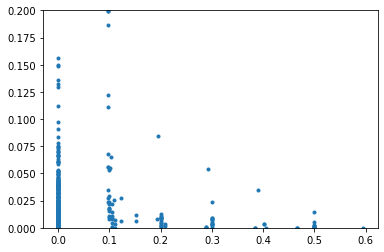

In [12]:
plotCorrelation('CholFraction','permeation',permeationVStemperature)
plt.ylim([0,0.2])

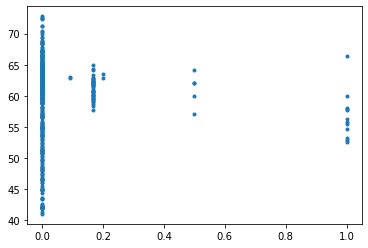

In [13]:
plotCorrelation('POPSFraction','APL',permeationVStemperature)

In [14]:
data = {}
for prop in permeationVStemperature[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in permeationVStemperature:
    for prop in permeationVStemperature[ID]:
        if prop == 'path':
            continue
        data[prop].append(permeationVStemperature[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)
#print (df)

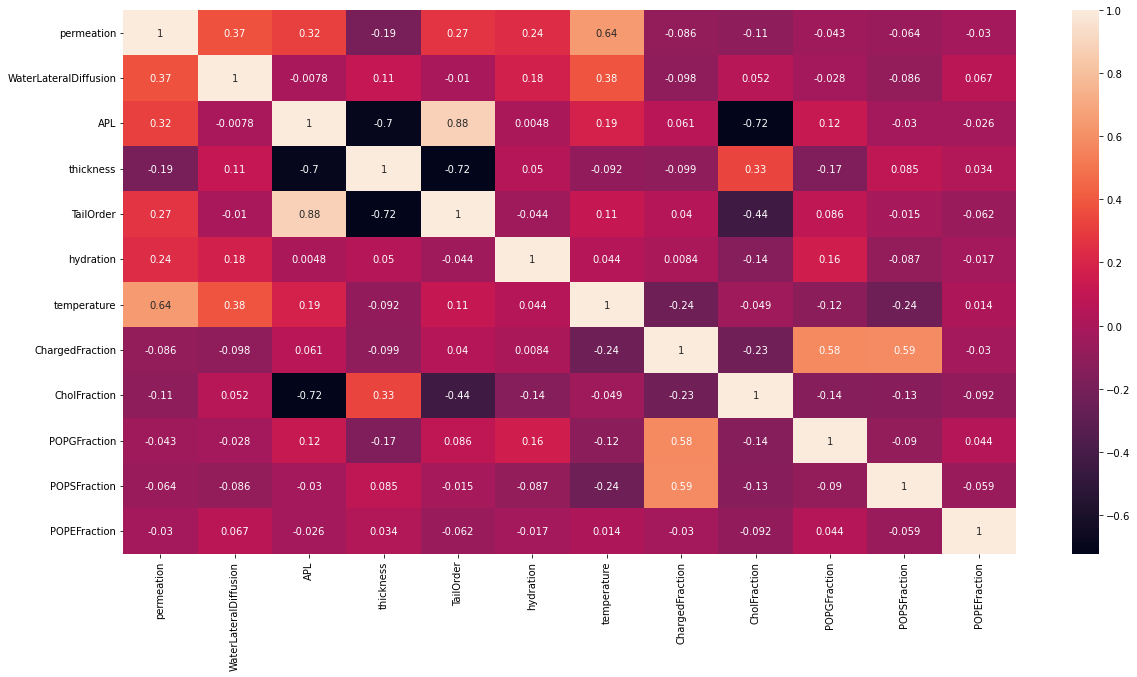

In [15]:
corrMatrix = df.corr()
#print (corrMatrix)
plt.figure(figsize = (20,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()


In [70]:
scipy.stats.pearsonr(data['ChargedFraction'],data['APL'])

(0.06608743924888374, 0.15170152112878688)

In [71]:
scipy.stats.spearmanr(data['ChargedFraction'],data['APL'])

SpearmanrResult(correlation=-0.008487646519376264, pvalue=0.8540815067557631)

In [52]:
df

,temperature,permeation,APL,CholFraction,POPGFraction,POPSFraction,POPEFraction,hydration,thickness,ChargedFraction,WaterLateralDiffusion,PermeationDiffusionRatio,area,TailOrder
0,310.15,0.018045,58.912310,0.099099,0.0,0.000000,0.0,40.540541,4.200446,0.000000,4.7147,0.003827,1.884156,-0.162092
1,310.00,0.019490,64.967140,0.000000,0.0,0.000000,0.0,45.000000,4.004265,0.000000,4.7157,0.004133,1.539240,-0.128373
2,313.00,0.078335,65.279236,0.000000,0.0,0.000000,0.0,45.000000,4.064088,0.000000,4.9253,0.015905,1.531881,-0.136642
3,310.00,0.000000,40.991445,0.593750,0.0,0.000000,0.0,50.000000,4.018039,0.000000,5.3119,0.000000,1.561301,-0.245352
4,315.00,0.014511,53.579101,0.104167,0.0,0.000000,0.0,40.312500,4.352813,0.000000,5.1716,0.002806,10.750460,-0.211341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,298.00,0.005015,59.891034,0.000000,0.0,0.166667,0.0,49.458333,4.169058,0.166667,2.1653,0.002316,0.601092,-0.146895
468,303.00,0.000000,61.151473,0.000000,0.0,0.000000,0.0,28.958333,2.560888,0.000000,3.1398,0.000000,0.588702,-0.159199
469,298.00,0.000000,53.233046,0.000000,0.0,1.000000,0.0,35.000000,4.641512,1.000000,3.6934,0.000000,1.202261,-0.213670
470,300.00,0.009092,58.190420,0.000000,0.0,0.000000,0.5,35.554688,4.250576,0.000000,3.9584,0.002297,2.199675,-0.177945


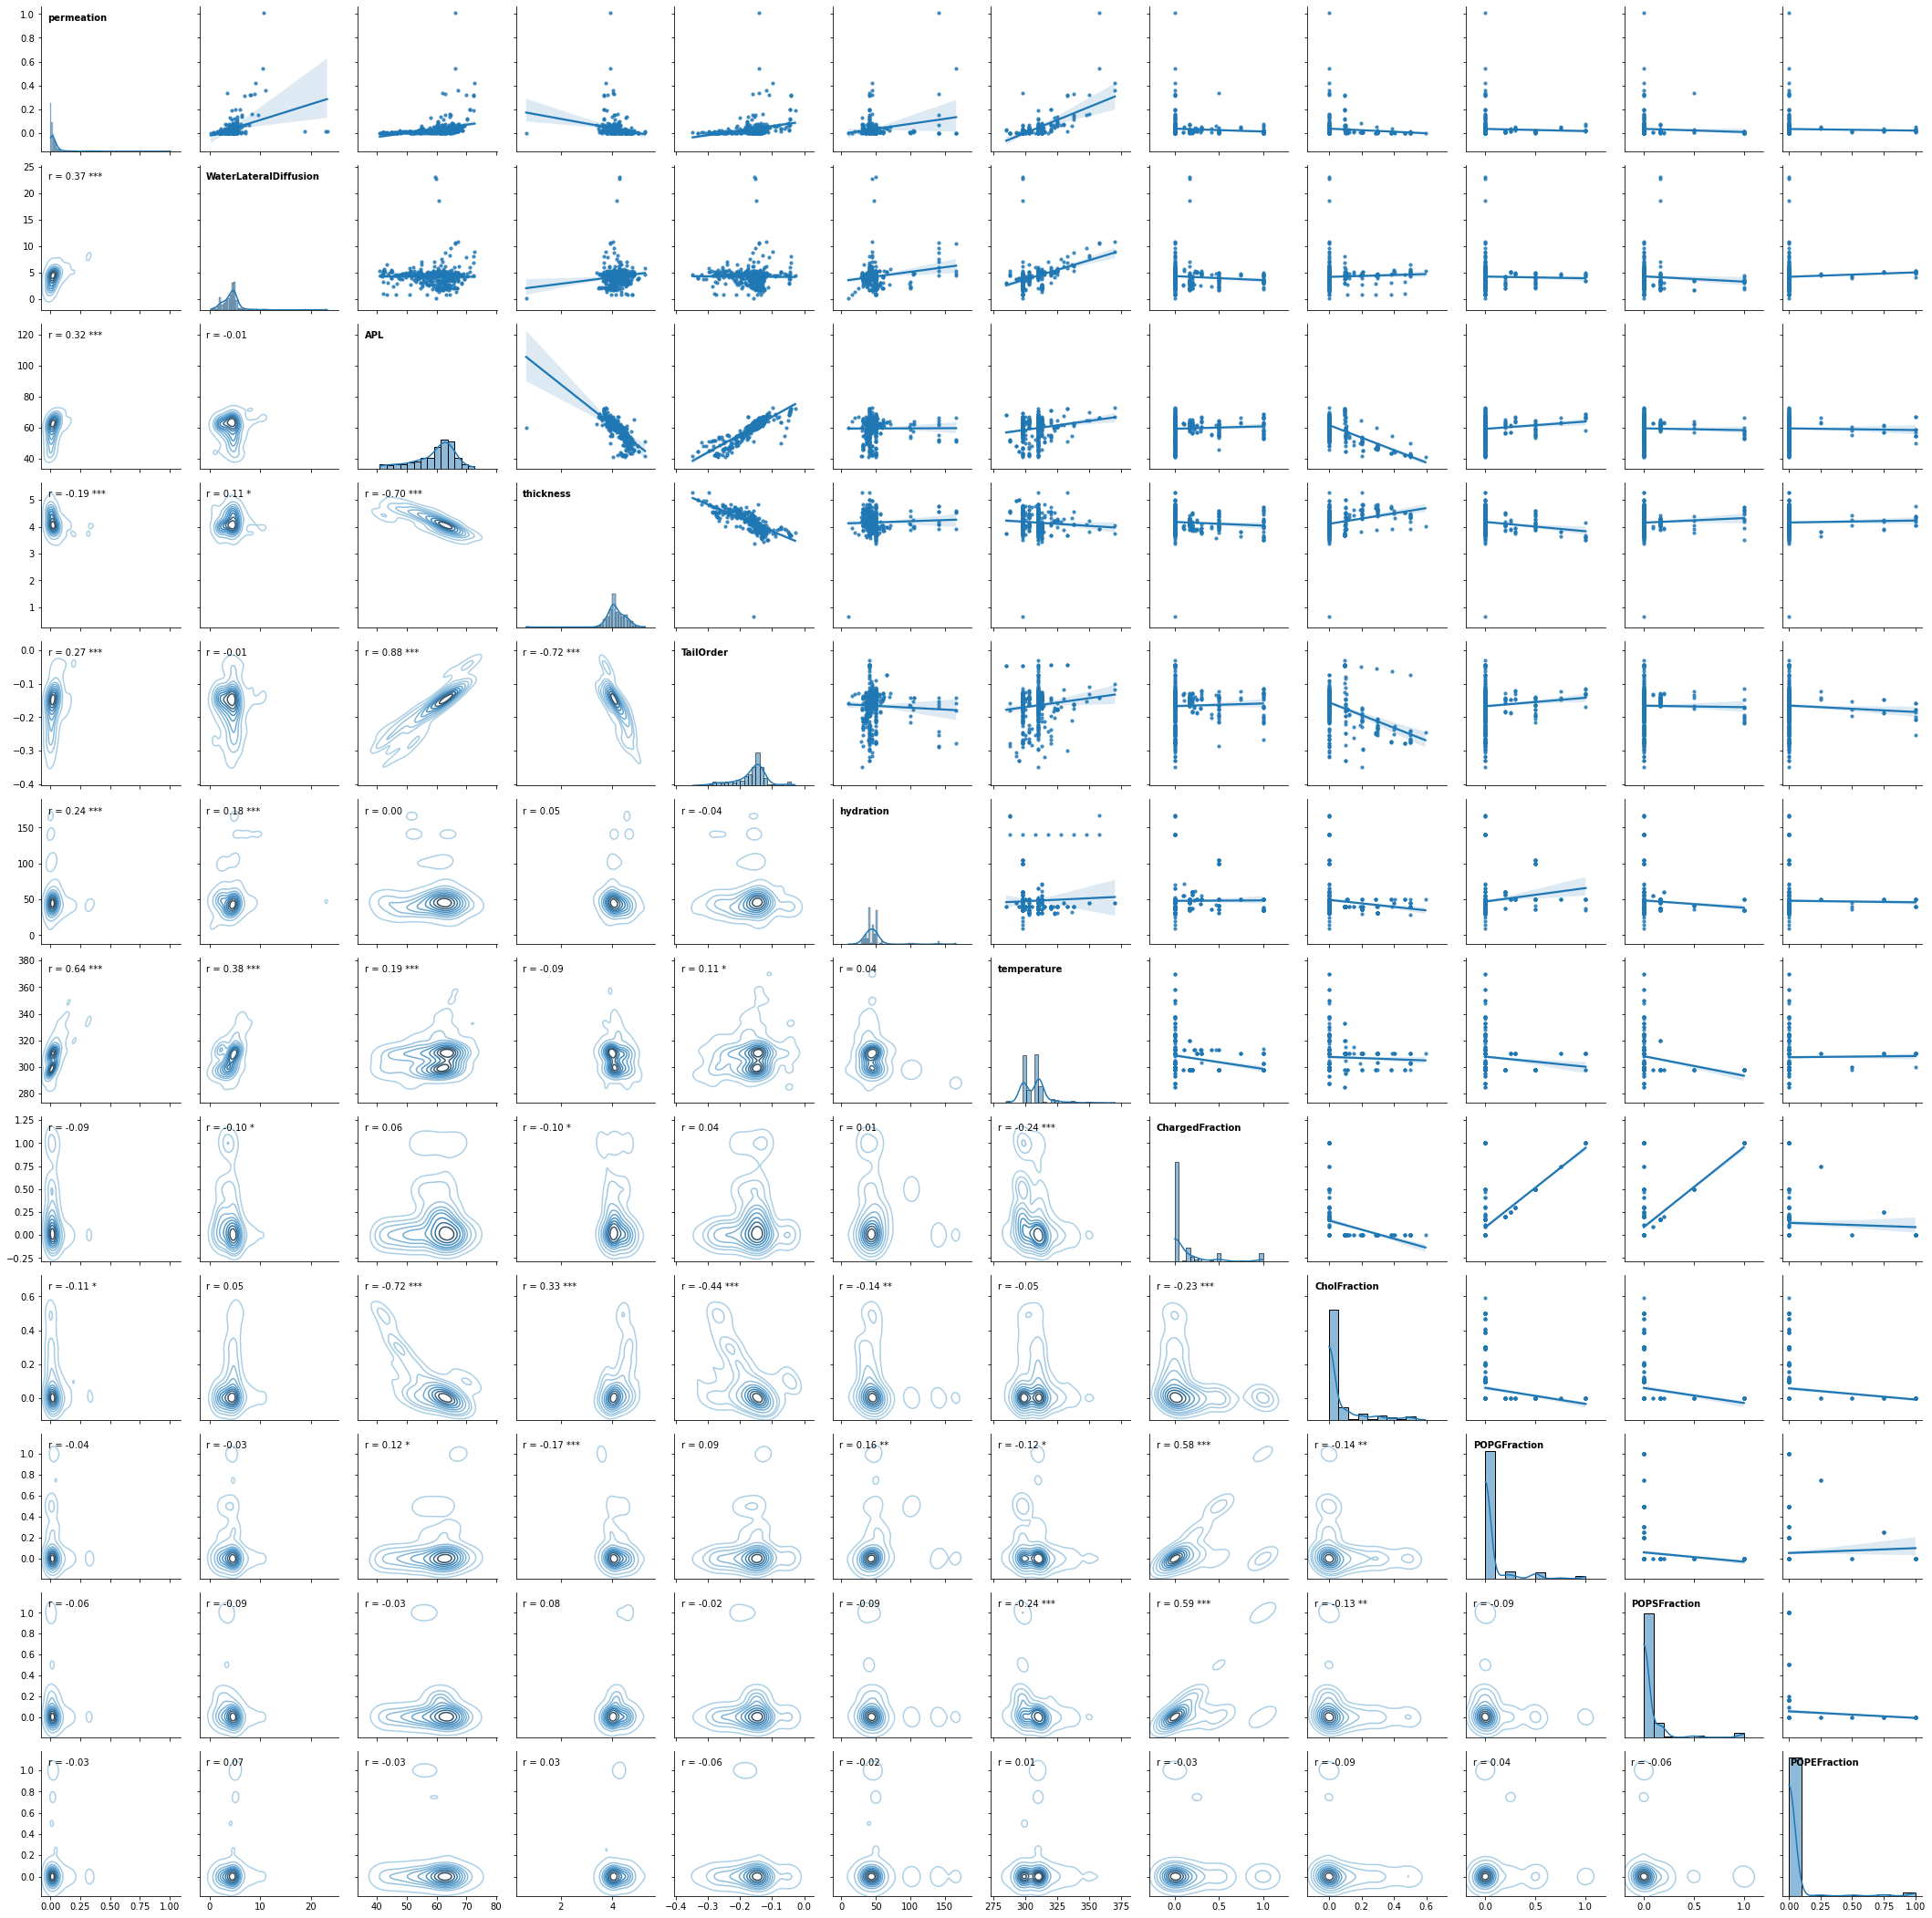

In [16]:
from scipy import stats

def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10})#, lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/statsmodels/robust/robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/statsmodels/robust/robust_linear_model.py:28

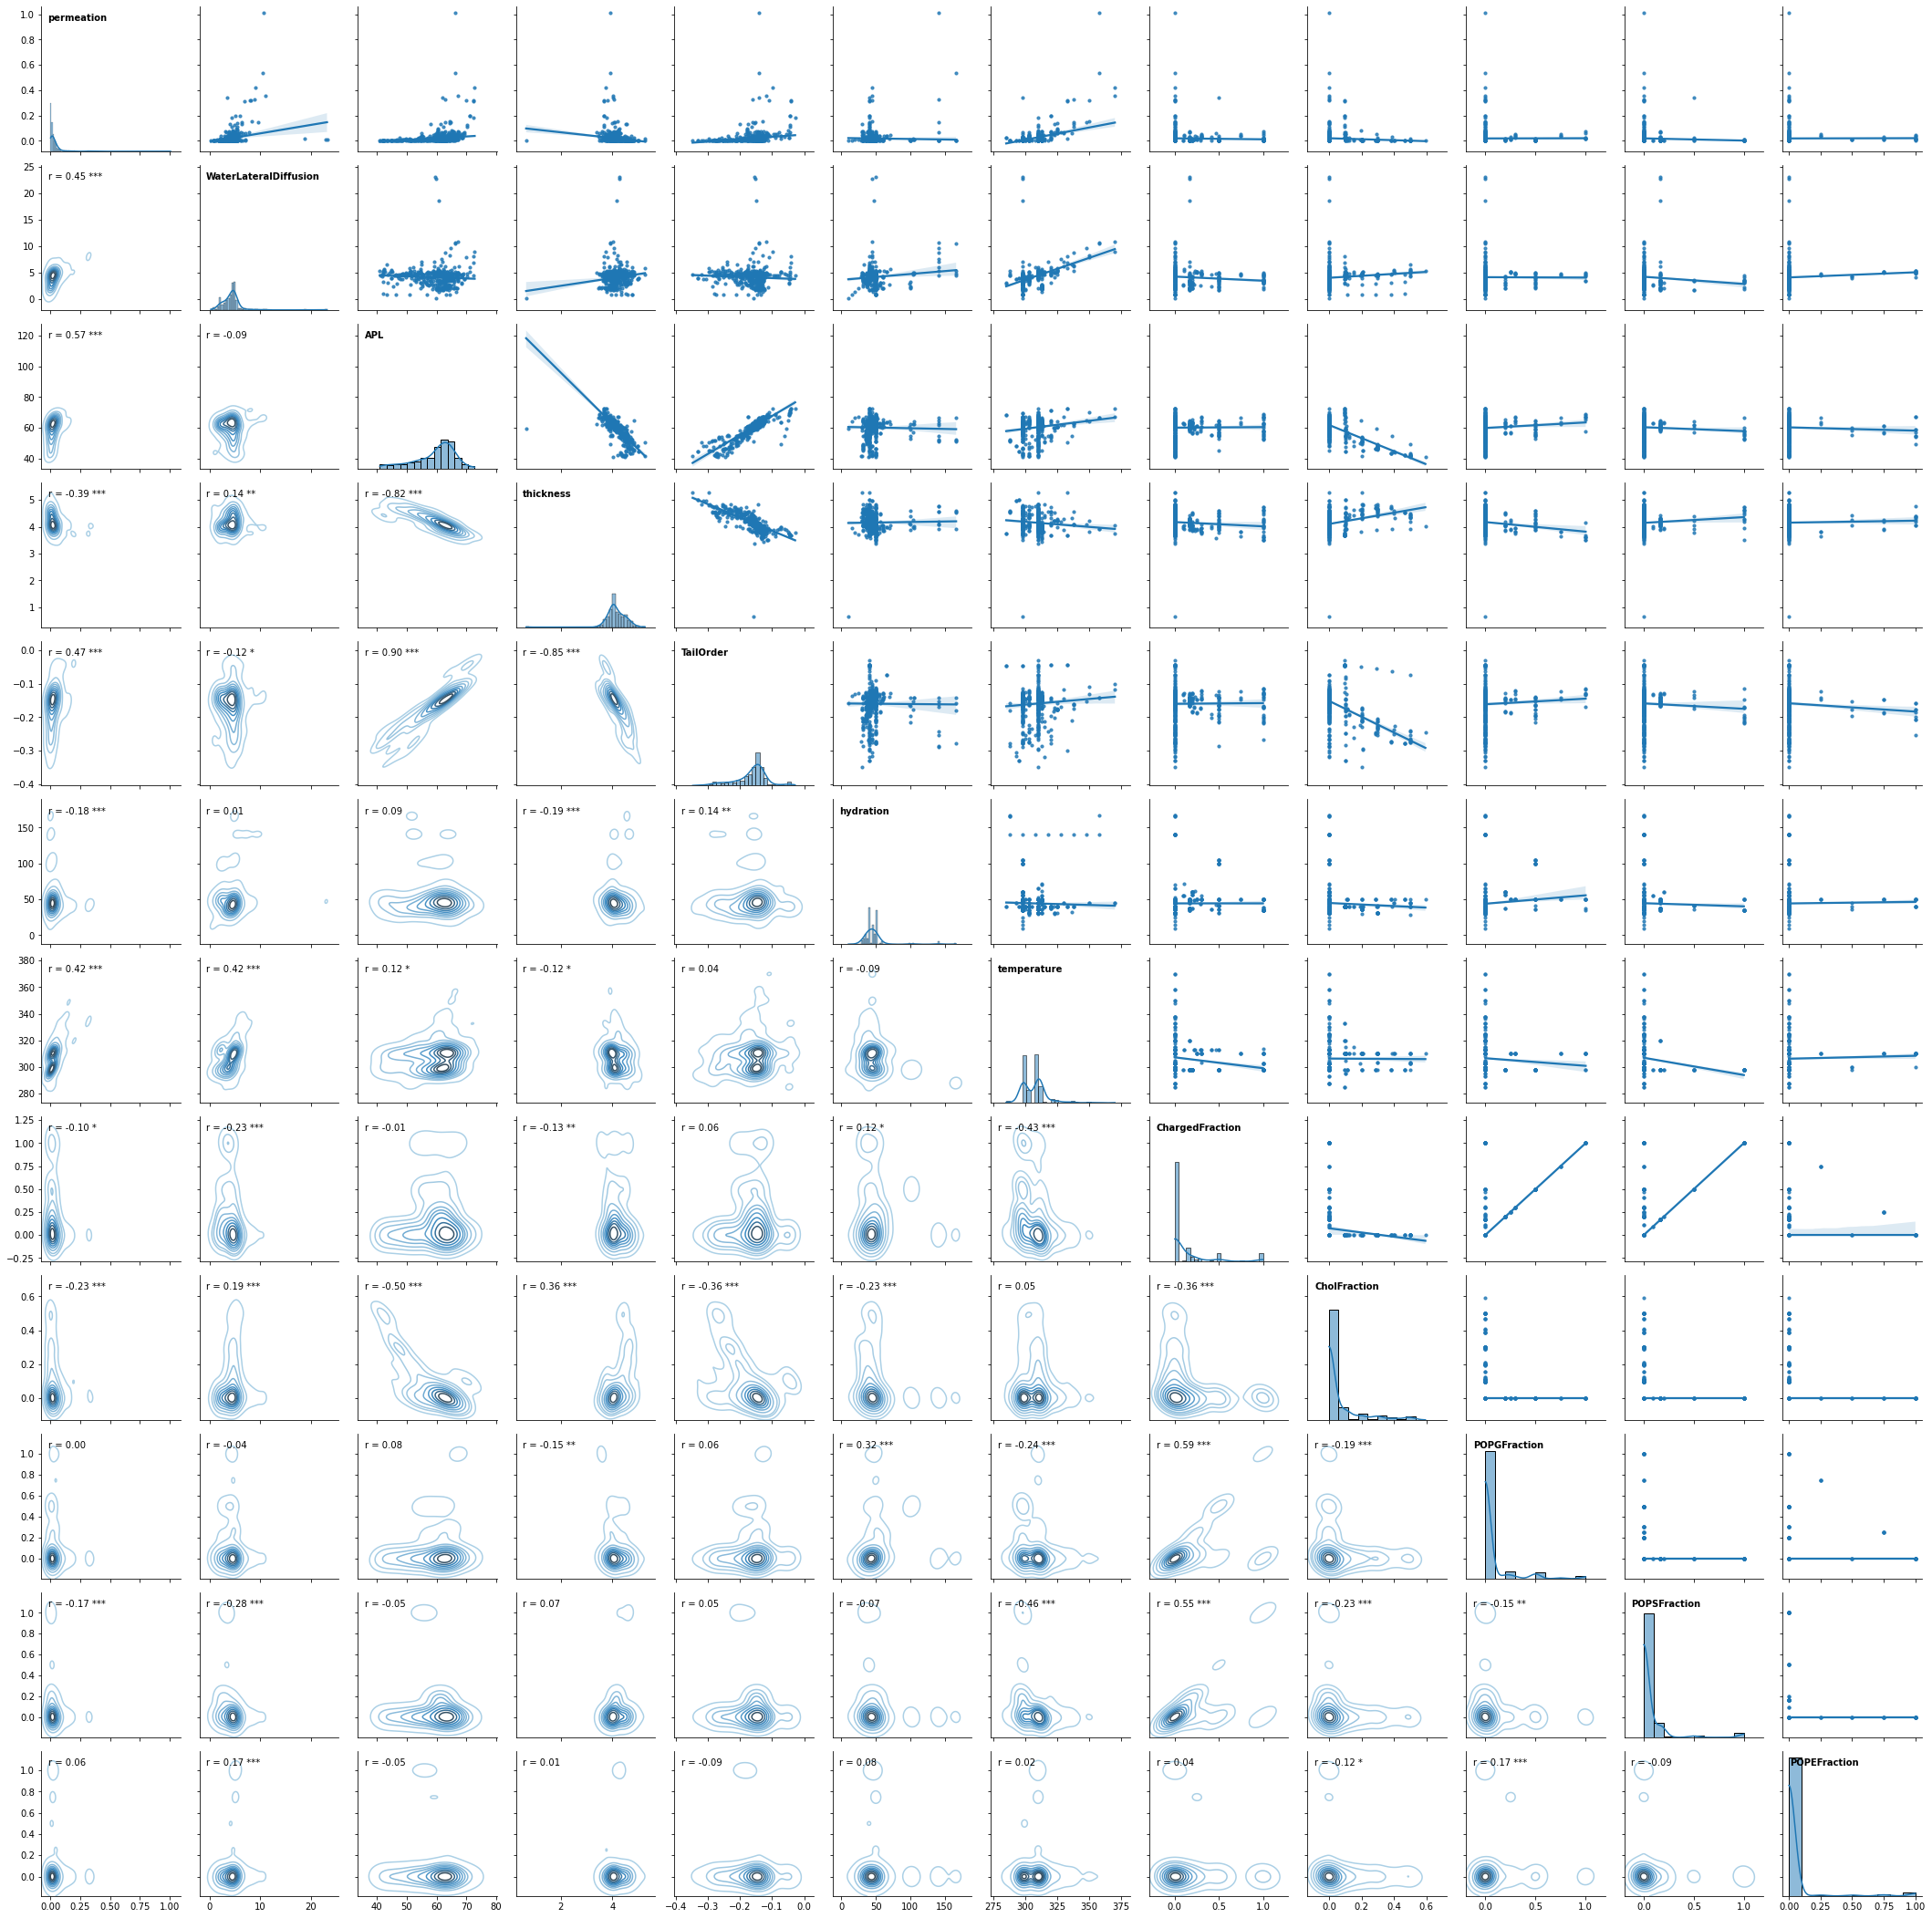

In [17]:
from scipy import stats

def corrfunc(x, y, **kws):
  #r, p = stats.pearsonr(x, y)
  r, p = stats.spearmanr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10}, order = 1, robust = True ) #lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

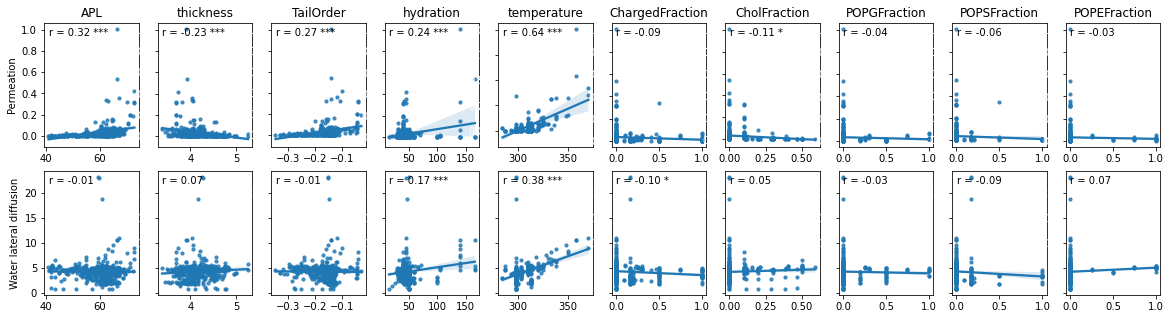

In [21]:
def CalcCorrCoeff(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        #if permeationVStemperature[ID][prop1] < 30:
        list1.append(value1)
        list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars

plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             'TailOrder',
             'hydration',
              'temperature',
              'ChargedFraction',
              'CholFraction',
              'POPGFraction',
              'POPSFraction',
              'POPEFraction'
             ]

for i in range(1,11):
    #print(i)
    
    plt.subplot(2, 10, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 10, i+10)
    if i+10 == 11:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

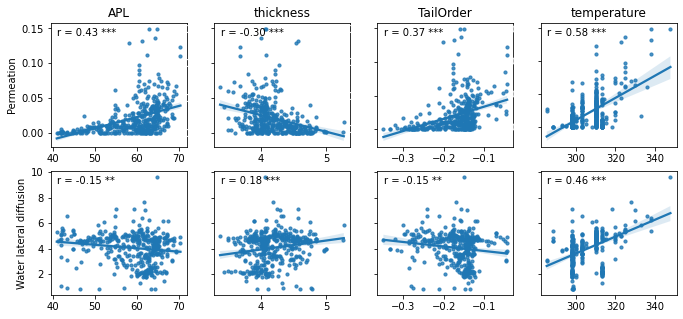

In [30]:
plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             'TailOrder',
             #'hydration',
              'temperature',
              #'ChargedFraction',
              #'CholFraction',
              #'POPGFraction',
              #'POPSFraction',
              #'POPEFraction'
             ]

for i in range(1,5):
    #print(i)
    
    plt.subplot(2, 7, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 7, i+7)
    if i+7 == 8:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')
    
plt.savefig('PermDiffDep.pdf')

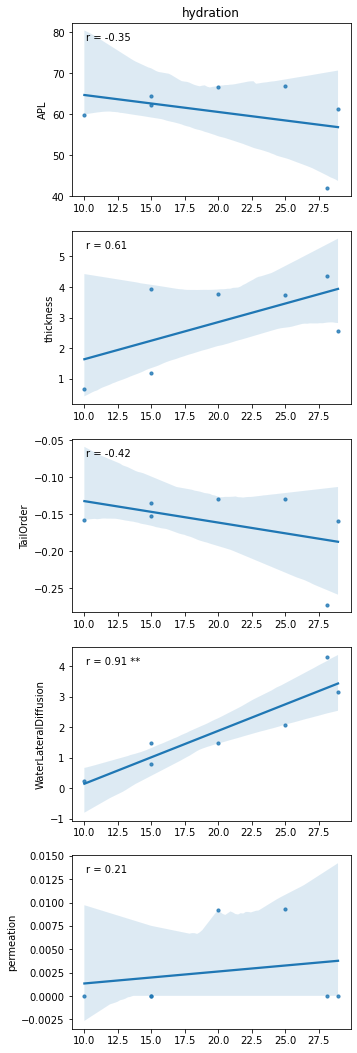

In [34]:
def CalcCorrCoeffFilterHYD(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        if permeationVStemperature[ID]['hydration'] < 30:
            list1.append(value1)
            list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars



plt.figure(figsize=(5,30))

properties = ['APL', 
             'thickness',
             'TailOrder',
              'WaterLateralDiffusion',
              'permeation'
             #'hydration',
             # 'temperature',
              #'ChargedFraction',
              #'CholFraction',
             #'POPGFraction',
             #'POPSFraction',
             #'POPEFraction'
             ]

for i in range(1,6):
    #print(i)
    
    plt.subplot(8, 1, i)
    if i ==1:
        plt.title('hydration')
    plt.ylabel(properties[i-1])
    #else:
    #    plt.yticks(color = 'w')
    CalcCorrCoeffFilterHYD('hydration',properties[i-1])
    
    #plt.subplot(2, 7, i+7)
    #if i+7 == 8:
    #    plt.ylabel('Water lateral diffusion')
    #else:
    #    plt.yticks(color = 'w')
    #CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

<AxesSubplot:>

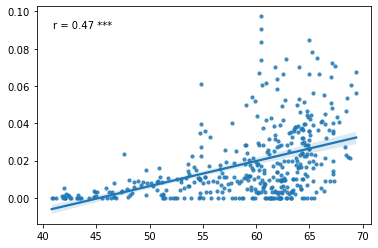

In [44]:
prop1 = 'APL'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

<AxesSubplot:>

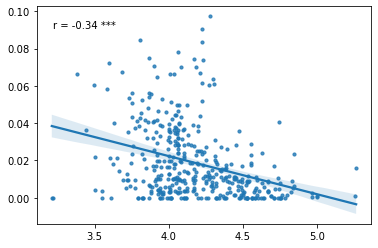

In [46]:
prop1 = 'thickness'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['thickness'] > 3 and permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

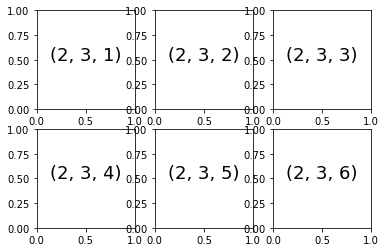

In [26]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')

In [17]:
CHARMMsum = 0
CHARMMcount = 0
OTHERsum = 0
OTHERcount = 0


for i in permeationVStemperature:
    if permeationVStemperature[i]['temperature'] > 311:
        continue
    FF = permeationVStemperature[i]['ForceField']
    permeation = permeationVStemperature[i]['permeation']
    if 'CHARMM' in FF:
        CHARMMsum += permeation
        CHARMMcount += 1
    else:
        OTHERsum += permeation
        OTHERcount += 1
        
print(CHARMMsum/CHARMMcount, OTHERsum/OTHERcount)

0.022451603432762885 0.0161826549286993


In [30]:
PermSum = 0
count = 0

for system in systems:
    try:
        rate = getWaterPermeationRate(system)
    except:
        continue
    
    POPCFraction = calcLipidFraction(system, 'POPC')
    if POPCFraction !=1:
        continue
        
    try:
        print(system['FF'],rate)
    except:
        continue
    
    if 'erger' in system['FF']:
        PermSum += rate
        count += 1
    else:
        continue

print(PermSum/count)

Slipids for lipids, Kohagen for NaCl 0.01949014206838082
CHARMM36 0.07833508371268842
CHARMM36 with ECC-scaled ions 0.005953114619755245
Slipids for lipids and Smith & Dang for ions 0.02263046127705189
Berger 0.0664680316607067
ECC-lipids 0.019584461389136443
Slipids for lipids and Smith & Dang for ions 0.4185416693886935
CHARMM36 0.035430855711133455
CHARMM36 0.04615557079567058
CHARMM36 0.027108642297276397
CHARMM36 0.033977209852677936
ECC-CHARMM36 0.017514570559426682
ECC-lipids 0.03852096334779376
MacRog 0.01836160920692734
MacRog 0.009074460849276454
Slipids 0.04041601983034868
ECC-lipids 0.006747985728991755
CHARMM36 0.02638957733171557
MacRog 0.0092368306901786
Lipid17 0.043274953984101555
ECC-lipids 0.009780529305486868
Berger 0.02090348769797966
CHARMM36 0.03620380086663269
CHARMM36 and CHARMM TIP3P 0.03545506240904034
CHARMM36 0.023838183025558072
ECC-lipids 0.01672787336914512
MacRog 0.012607522809584125
ECC-lipids 0.003366720593537209
GAFFlipid 0.04310469299843746
CHARMM36